# Data-scientistとしてのKepler

::::{admonition} ask ai
:class: tip

* PythonでKepler方程式の近似解を求めます

:::{admonition} ask ai repeatedly
:class: seealso

* Kepler方程式は、sympyのシンボルで定義し、lambdifyでnumpyに渡してください。
* scipyのfsolveを使ってください。
* sympyのベッセル関数 `jv` を使って近似して下さい。
:::
::::

## 1. PythonでKepler方程式の近似解を求める

### 1.1. Newton法

In [1]:
import sympy as sp
import numpy as np
from scipy.optimize import fsolve

In [2]:
# SymPyでシンボルを定義
E, M, e = sp.symbols('E M e')  # E: 離心近点角, M: 平均近点角, e: 軌道離心率

In [3]:
# ケプラー方程式を定義
kepler_eq = E - e * sp.sin(E) - M

In [4]:
kepler_eq

E - M - e*sin(E)

In [5]:
sp.diff(kepler_eq, E)

-e*cos(E) + 1

In [6]:
# SymPyの方程式をNumPy対応の関数に変換
kepler_eq_func = sp.lambdify((E, M, e), kepler_eq, 'numpy')  # 数値用の関数
kepler_eq_derivative = sp.lambdify((E, e), sp.diff(kepler_eq, E), 'numpy')  # 導関数

In [7]:
# ニュートン法を実装
def solve_kepler_numpy(M_val, e_val, tol=1e-8, max_iter=100):
    """
    SymPyシンボルを使って定義したケプラー方程式を
    lambdifyで数値計算し、ニュートン法で解を求める。

    引数:
        M_val (float): 平均近点角（ラジアン）
        e_val (float): 軌道離心率（0 ≤ e < 1）
        tol (float): 許容誤差
        max_iter (int): 最大反復回数

    戻り値:
        E_val (float): 離心近点角（ラジアン）
    """
    # 初期推定値
    E_val = M_val if e_val < 0.8 else np.pi  # 離心率が高い場合はpiを初期値に

    for i in range(max_iter):
        # ケプラー方程式とその導関数を評価
        f_val = kepler_eq_func(E_val, M_val, e_val)
        f_prime_val = kepler_eq_derivative(E_val, e_val)

        # ニュートン法による更新
        E_new = E_val - f_val / f_prime_val

        # 収束判定
        if abs(E_new - E_val) < tol:
            return E_new

        E_val = E_new

    raise RuntimeError(f"ニュートン法が収束しませんでした (最大反復回数 {max_iter})")

In [8]:
# 使用例
M_numeric = np.radians(30)  # 平均近点角 (30度をラジアンに変換)
e_numeric = 0.2  # 離心率

E_numeric = solve_kepler_numpy(M_numeric, e_numeric)
print("離心近点角 E (ラジアン):", E_numeric)
print("離心近点角 E (度):", np.degrees(E_numeric))

離心近点角 E (ラジアン): 0.6436173778335976
離心近点角 E (度): 36.87655937114201


### 1.2. SymPyの`fsolve()`を使う

* [Optimization and root finding (scipy.optimize) — SciPy v1.15.3 Manual](https://docs.scipy.org/doc/scipy/reference/optimize.html#id3)
* [fsolve — SciPy v1.15.3 Manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)

In [9]:
fsolve(kepler_eq_func, M_numeric, args=(M_numeric, e_numeric))

array([0.64361738])

### 1.3. Bessel関数を使う

* [Kepler's equation - Wikipedia](https://en.wikipedia.org/wiki/Kepler%27s_equation#Inverse_problem)#Inverse_problem

In [10]:
n = sp.symbols('n', integer=True)  # フーリエ級数の添字 (シンボリックに定義)

In [76]:
kepler_eq2 = M+sp.Sum((2/n)*sp.besselj(n, n*e)*sp.sin(n*M), (n, 1, 10))
kepler_eq2

M + Sum(2*sin(M*n)*besselj(n, e*n)/n, (n, 1, 10))

In [12]:
kepler_eq_func2 = sp.lambdify((E, M, e), kepler_eq2, 'sympy')

In [13]:
float(kepler_eq_func2(M_numeric, M_numeric, e_numeric))

0.6436173831881328

## 2. プロットしてKeplerの第二法則を検証する

In [15]:
import matplotlib.pyplot as plt

In [16]:
theta = np.linspace(0, 2*np.pi, 100)

In [60]:
eccentricity = 0.0935
# eccentricity = 0.9673 # 1P/Halley
# eccentricity = 0.0935 # mars
# eccentricity = 0.0167 # earth

In [61]:
a = 1
b = np.sqrt(a**2 - eccentricity**2)
print(a, b, a*eccentricity)

1 0.9956192796445839 0.0935


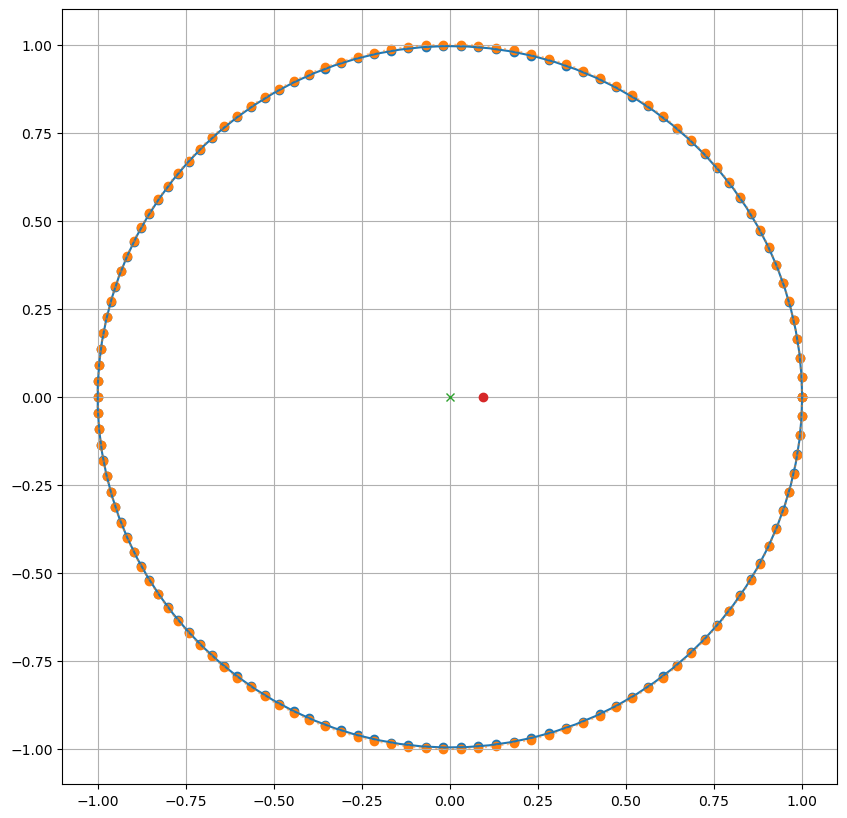

In [62]:
ax = plt.figure(figsize=(10, 30)).add_subplot()
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_aspect('equal')

X0 = np.cos(theta)
Y0 = b * np.sin(theta)
ax.plot(X0, Y0)

X1 = np.cos(theta)
Y1 = np.sin(theta)
ax.plot(X1, Y1, ':', alpha=.5)

ax.plot(0, 0, 'x')
ax.plot(eccentricity, 0, 'o')

Ms = np.linspace(0, 2*np.pi, 127)
Es = [solve_kepler_numpy(t, eccentricity) for t in Ms]

ax.scatter(a*np.cos(Es), b*np.sin(Es))
ax.scatter(a*np.cos(Es), a*np.sin(Es))

plt.grid()
plt.show()

In [63]:
np.diff(Ms)

array([0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986655,
       0.04986655, 0.04986655, 0.04986655, 0.04986655, 0.04986

In [64]:
np.diff(Es), np.max(np.diff(Es))*180/np.pi, np.min(np.diff(Es))*180/np.pi

(array([0.05500712, 0.05498998, 0.0549558 , 0.05490478, 0.05483725,
        0.0547536 , 0.05465434, 0.05454003, 0.05441133, 0.05426898,
        0.05411374, 0.05394646, 0.053768  , 0.05357926, 0.05338117,
        0.05317467, 0.05296068, 0.05274016, 0.05251402, 0.05228318,
        0.05204852, 0.0518109 , 0.05157116, 0.05133009, 0.05108846,
        0.05084699, 0.05060636, 0.05036721, 0.05013016, 0.04989577,
        0.04966456, 0.04943703, 0.04921361, 0.04899474, 0.04878079,
        0.04857212, 0.04836903, 0.04817183, 0.04798077, 0.04779609,
        0.04761801, 0.04744672, 0.04728239, 0.04712518, 0.04697522,
        0.04683264, 0.04669754, 0.04657003, 0.04645017, 0.04633805,
        0.04623372, 0.04613725, 0.04604868, 0.04596805, 0.0458954 ,
        0.04583076, 0.04577415, 0.04572559, 0.0456851 , 0.04565269,
        0.04562837, 0.04561216, 0.04560405, 0.04560405, 0.04561216,
        0.04562837, 0.04565269, 0.0456851 , 0.04572559, 0.04577415,
        0.04583076, 0.0458954 , 0.04596805, 0.04

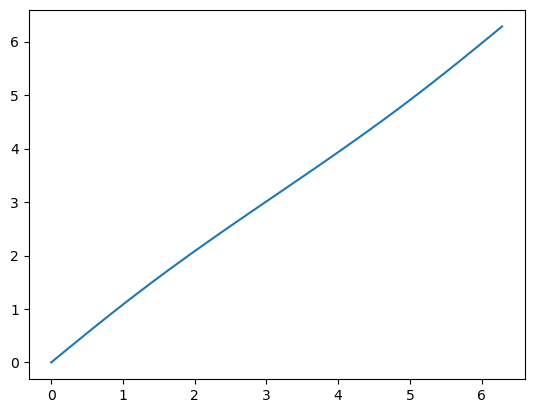

In [65]:
plt.plot(Ms, Es)

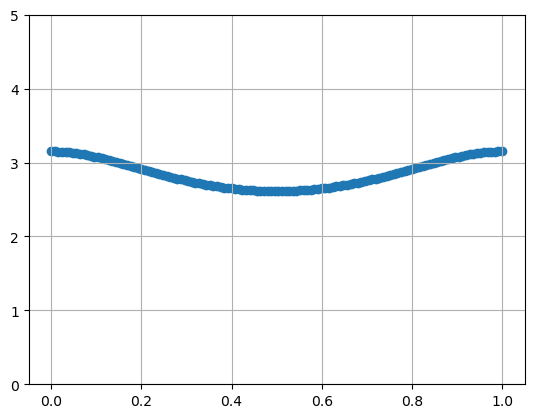

In [75]:
plt.scatter(np.linspace(0, 1, len(np.diff(Es))), np.diff(Es)*180/np.pi)
plt.ylim([0, 5])
plt.grid()
plt.show()

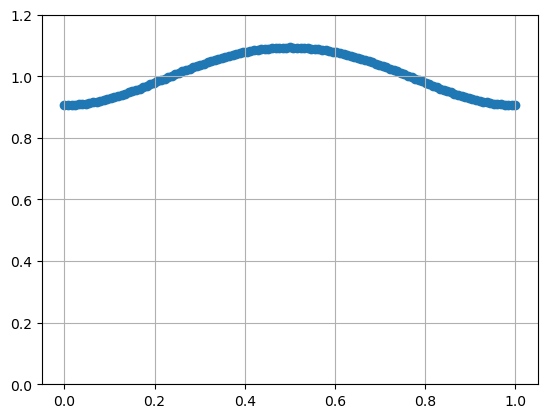

In [72]:
Rs = [np.sqrt((a*(np.cos(t)-eccentricity))**2 + (b*np.sin(t))**2) for t in Es]
# Rs
plt.scatter(np.linspace(0, 1, len(Rs)), Rs)
plt.ylim([0, 1.2])
plt.grid()
plt.show()

In [68]:
[s*t/2 for s, t in zip(np.diff(Es), Rs)];

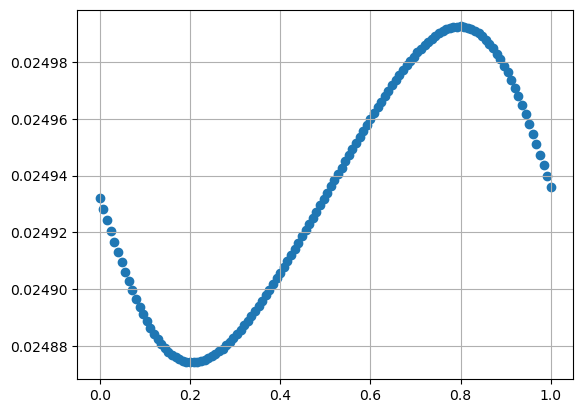

In [73]:
# 偏心した円軌道だと仮定して、更に 角速度 × 半径 が一定と仮定してみる
Y3 = [s*t/2 for s, t in zip(np.diff(Es), Rs)]
plt.scatter(np.linspace(0, 1, len(Y3)), Y3)
# plt.ylim([0.024, 0.026])
plt.ticklabel_format(useOffset=False)
plt.grid()
plt.show()

In [70]:
np.diff([(t/2*a**2-((a*eccentricity)*np.sin(t))/2)*b/a for t in Es]);

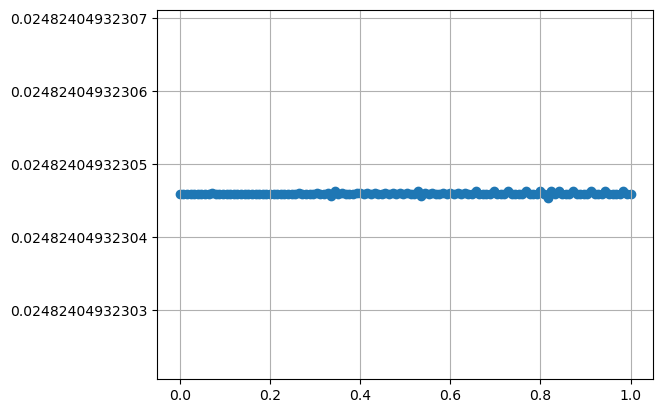

In [74]:
# 楕円軌道だと仮定して、単位時間あたりの楕円の焦点を頂点とする扇形の面積が一定と仮定してみる
# (扇形の面積 - 三角形の面積) × b/a
# ((弧の長さの比 × 半径の自乗) - (底辺 × 高さ)/2) × b/a
Y4 = np.diff([(t/2*a**2-((a*eccentricity)*np.sin(t))/2)*b/a for t in Es])
plt.scatter(np.linspace(0, 1, len(Y4)), Y4)
# plt.ylim([0.024, 0.026])
plt.ticklabel_format(useOffset=False)
plt.grid()
plt.show()